In [174]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from category_encoders import BinaryEncoder
from imblearn.under_sampling import OneSidedSelection
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._tree import TREE_LEAF
from xgboost import XGBClassifier

gc.enable()

pd.options.display.max_columns = 200
pd.options.display.max_rows = 15

In [58]:
df = pd.read_csv('train_features.csv')
labels = pd.read_csv('train_labels.csv')
df = pd.concat([df, labels], axis=1)
print(df.shape)
df.head()

(37745, 105)


,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method,id,charged_off
0,43373,NaN,12000,12000,36 months,16.02%,422.01,C,C5,Driver,4 years,MORTGAGE,81000.0,NaN,NaN,debt_consolidation,Debt consolidation,280xx,NC,12.76,0,Dec-2005,1,48.0,NaN,7,0,4912,23.5%,15,w,0,48.0,Individual,NaN,NaN,0,0,174783,1,2,0,4,13.0,33668,82.0,2,5,2962,63.0,20900,1,1,2,9,24969.0,588.0,89.3,0,0,145.0,23,1,1,1,8.0,NaN,1.0,NaN,2,2,2,2,2,9,4,5,2,7,0.0,0,0,2,92.9,100.0,0,0,206618,38580,5500,40863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,43373,0
1,24414,NaN,6300,6300,36 months,14.07%,215.54,C,C3,GMP Lead,4 years,RENT,39000.0,NaN,NaN,debt_consolidation,Debt consolidation,920xx,CA,21.42,0,Mar-2012,1,NaN,NaN,10,0,11876,59.4%,12,w,0,NaN,Individual,NaN,NaN,0,0,31046,0,1,0,2,14.0,19170,83.0,3,8,5153,72.0,20000,1,0,1,10,3105.0,6877.0,59.3,0,0,17.0,72,8,8,0,8.0,NaN,6.0,NaN,0,6,7,7,8,2,9,10,7,10,0.0,0,0,3,100.0,42.9,0,0,43140,31046,16900,23140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,24414,0
2,46723,NaN,4500,4500,36 months,7.21%,139.38,A,A3,Accounts,3 years,RENT,78000.0,NaN,NaN,debt_consolidation,Debt consolidation,906xx,CA,2.17,0,May-2000,2,NaN,NaN,13,0,1715,5.2%,19,w,0,NaN,Individual,NaN,NaN,0,0,35329,0,8,1,2,10.0,33614,106.0,1,1,1196,54.0,33300,4,0,3,3,2718.0,21585.0,7.4,0,0,166.0,218,10,10,0,31.0,NaN,1.0,NaN,0,3,3,3,4,13,5,6,3,13,0.0,0,0,2,100.0,0.0,0,0,65092,35329,23300,31792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,46723,0
3,24878,NaN,12000,12000,36 months,9.44%,384.06,B,B1,Client Processing Associate,10+ years,MORTGAGE,62000.0,NaN,NaN,debt_consolidation,Debt consolidation,441xx,OH,13.76,0,Feb-2003,0,NaN,NaN,22,0,9404,16.3%,33,w,0,NaN,Individual,NaN,NaN,0,0,75160,4,1,0,2,13.0,17123,67.0,6,9,6898,32.0,57600,3,1,2,12,3579.0,33602.0,17.0,0,0,162.0,179,1,1,1,1.0,NaN,5.0,NaN,0,1,3,9,13,7,20,25,3,22,0.0,0,0,7,100.0,0.0,0,0,133065,26527,40500,25465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,24878,0
4,39038,NaN,12000,12000,36 months,22.35%,460.47,D,D5,Construction Operator,10+ years,MORTGAGE,70000.0,NaN,NaN,debt_consolidation,Debt consolidation,751xx,TX,14.04,4,Nov-2001,2,13.0,NaN,18,0,17895,24.2%,45,w,0,13.0,Individual,NaN,NaN,0,7218,113702,9,2,2,4,6.0,16711,68.0,9,10,5373,35.0,73900,3,6,3,14,6317.0,32863.0,24.1,0,0,159.0,201,0,0,1,0.0,62.0,3.0,62.0,6,9,11,11,14,22,15,20,11,18,0.0,0,2,11,82.2,9.1,0,0,192842,34606,43300,24499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,39038,0


In [59]:
cell_count = np.product(df.shape)

missing_count  = df.isnull().sum()

total_missing = missing_count.sum()

print("Missing values in percentile format:", round(((total_missing/cell_count) * 100),
                                                   2), '%')

Missing values in percentile format: 17.82 %


# Remove useless columns
Data is missing entirely for some columns, so we remove them.

In [60]:
drop_columns = missing_count[missing_count == 37745].index.to_list()
drop_columns

['member_id', 'url', 'desc']

In [61]:
df = df.drop(labels=drop_columns, axis=1)

In [62]:
nulls = df.isnull().sum()
nulls

# I've decided to keep the sec_app data even though a large majority of it is missing. 
# data description https://docs.google.com/spreadsheets/d/1R_0o6LWrI93x2ge15jcKZ_auyRYTwH_pV6DLj3ej-ZQ/edit#gid=1444157382
# makes it seem important, indictation of existing debt is usually a good indication towards not being able to repay further

id                                         0
loan_amnt                                  0
funded_amnt                                0
term                                       0
int_rate                                   0
installment                                0
grade                                      0
                                       ...  
sec_app_num_rev_accts                  33007
sec_app_chargeoff_within_12_mths       33007
sec_app_collections_12_mths_ex_med     33007
sec_app_mths_since_last_major_derog    36077
disbursement_method                        0
id                                         0
charged_off                                0
Length: 102, dtype: int64

# At this point I felt like I lacked domain knowledge, so I tried to do some research on what sort of features we do not need.

In [63]:
df = df.drop(['earliest_cr_line', 'emp_title'], axis=1)
df = df.drop(['id', 'title', 'zip_code'], axis=1)

In [64]:
def categorize(l):
    uniques = sorted(list(set(l)))
    return [uniques.index(x) + 1 for x in l]

df["emp_length"] = ["0.5" if x == '< 1 year' else x for x in df["emp_length"]]
df.emp_length = df.emp_length.dropna()

# I wanted to use regex to format the employment length
I read employment length is a very important feature for loan applications

In [65]:
# have to drop the na or the regex below will bug out
df = df.dropna(subset=['emp_length'])
df.shape

(34468, 96)

In [66]:
reg = re.compile(r'(\d+\.?\d?)')
t = []
for emp in df.emp_length:
    value = reg.match(emp)
    t.append(float(value[0]) if value else 0)
df['emp'] = t

In [67]:
f = pd.value_counts(df['emp']).to_frame().reset_index()
f.columns = ['type','count']
f

,type,count
0,10.0,12707
1,2.0,3361
2,3.0,3066
3,0.5,2865
4,4.0,2435
5,1.0,2400
6,5.0,2319
7,6.0,1673
8,7.0,1440
9,8.0,1206


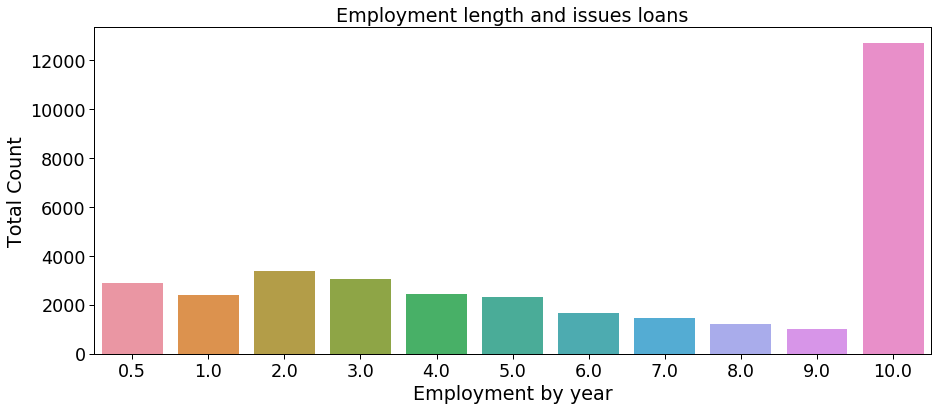

In [68]:
plt.subplots(figsize=(15,6))
sns.barplot(y='count', x='type', data=f)
plt.xlabel("Employment by year")
plt.ylabel("Total Count")
plt.title("Employment length and issues loans")
plt.show()

Overall I'd say there is a preference for people who have worked 10+ years for loan applications :P


In [72]:
# Here are a list of features that experts think are important 
df_exp = pd.DataFrame()
df_exp['annual_inc'] = df['annual_inc']
df_exp['delinq_2yrs'] = df['delinq_2yrs']
df_exp['dti'] = df['dti']
df_exp['emp_length'] = categorize(df['emp_length'])
df_exp['home_ownership'] = categorize(df['home_ownership'])
df_exp['installment'] = df['installment']
df_exp['int_rate'] = df['int_rate']
df_exp['loan_amnt'] = df['loan_amnt']
df_exp['purpose'] = categorize(df['purpose'])
df_exp['term'] = categorize(df['term'])
df_exp['acc_now_delinq'] = df['acc_now_delinq']

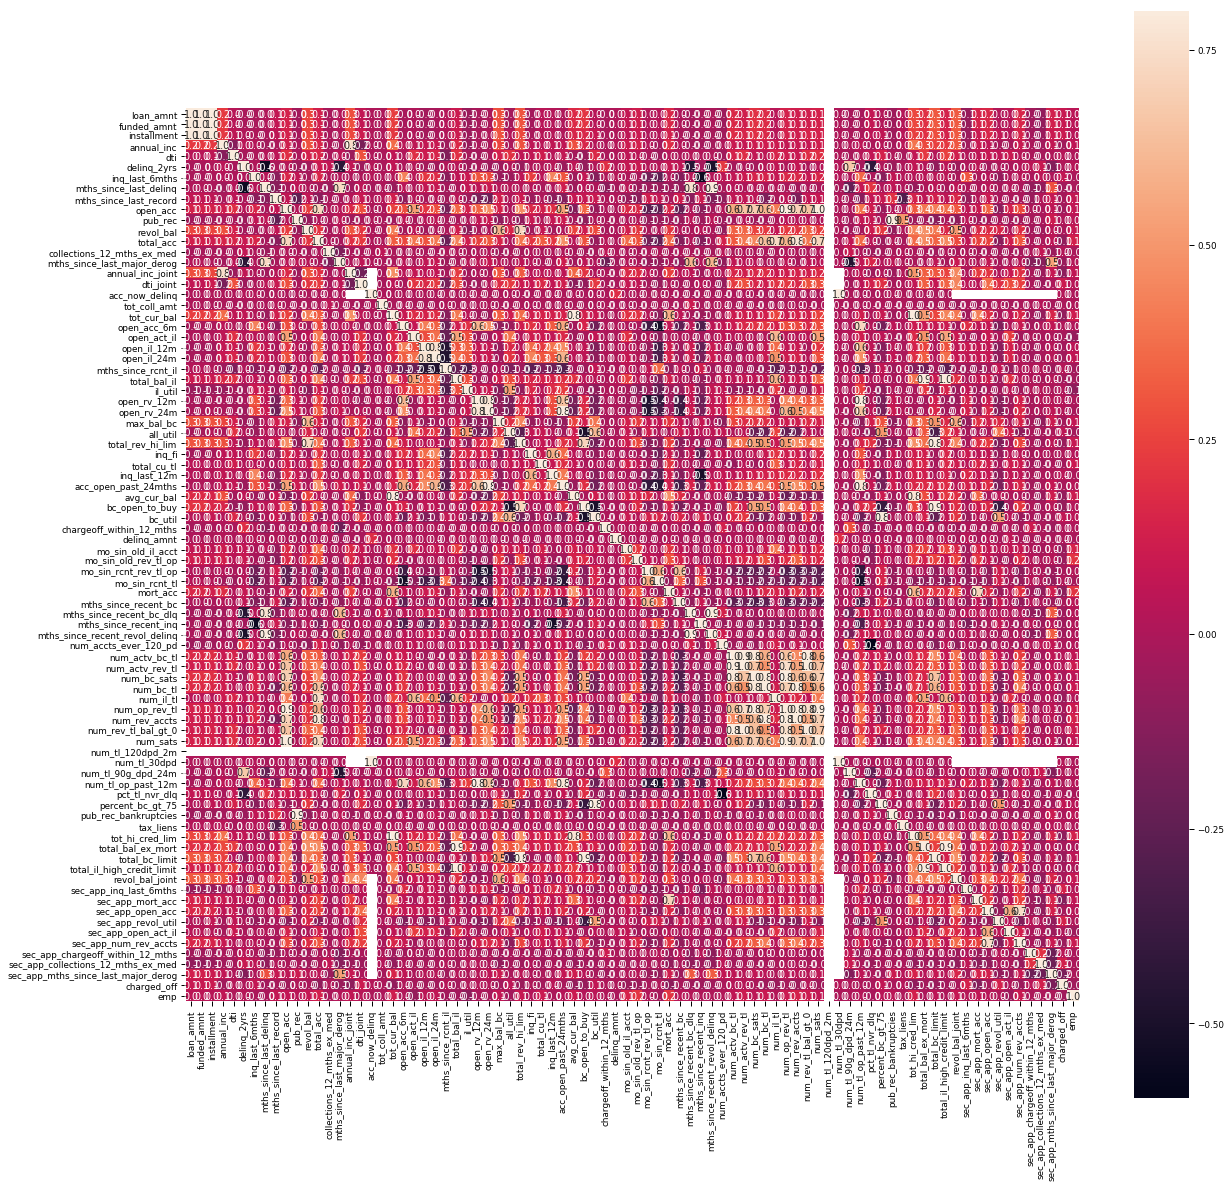

In [141]:
plt.figure(figsize=(20,20))
sns.set_context("paper")
sns.heatmap(df.corr(), vmax=.8, square=True, annot=True, fmt='.1f')

In [77]:
y = df['charged_off']
X = df_exp
X['int_rate'] = X['int_rate'].map(lambda x: re.sub(r'\W+', '', x))
X

,annual_inc,delinq_2yrs,dti,emp_length,home_ownership,installment,int_rate,loan_amnt,purpose,term,acc_now_delinq
0,81000.0,0,12.76,6,2,422.01,1602,12000,3,1,0
1,39000.0,0,21.42,6,4,215.54,1407,6300,3,1,0
2,78000.0,0,2.17,5,4,139.38,721,4500,3,1,0
3,62000.0,0,13.76,3,2,384.06,944,12000,3,1,0
4,70000.0,4,14.04,3,2,460.47,2235,12000,3,1,0
5,100000.0,0,0.00,1,4,1221.71,1549,35000,4,1,0
6,130000.0,0,3.39,1,2,407.08,1273,18000,9,2,0
...,...,...,...,...,...,...,...,...,...,...,...
37738,37000.0,1,29.39,7,2,244.62,1358,7200,2,1,0
37739,126000.0,1,17.97,7,2,155.44,746,5000,4,1,0


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oss = OneSidedSelection()
X_resampled, y_resampled = oss.fit_sample(X, y)

In [162]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print("Decision tree - Imbalanced lean -One Sided Selection")
print(accuracy_score(y, dt.predict(X)))

Decision tree - Imbalanced lean -One Sided Selection
0.9319948938145526


In [163]:
test_data = pd.read_csv('test_features.csv')
test_data['int_rate'] = test_data['int_rate'].map(lambda x: re.sub(r'\W+', '', x))
test_data = test_data.fillna(value='999999')

reg = re.compile(r'(\d+\.?\d?)')
t = []
for emp in test_data.emp_length:
    value = reg.match(emp)
    t.append(float(value[0]) if value else 0)
    
test_data['emp'] = t

df_test = pd.DataFrame()
df_test['annual_inc'] = test_data['annual_inc']
df_test['delinq_2yrs'] = test_data['delinq_2yrs']
df_test['dti'] = test_data['dti']
df_test['emp_length'] = categorize(test_data['emp_length'])
df_test['home_ownership'] = categorize(test_data['home_ownership'])
df_test['installment'] = test_data['installment']
df_test['int_rate'] = test_data['int_rate']
df_test['loan_amnt'] = test_data['loan_amnt']
df_test['purpose'] = categorize(test_data['purpose'])
df_test['term'] = categorize(test_data['term'])
df_test['acc_now_delinq'] = test_data['acc_now_delinq']
df_test = df_test.astype('float64')

In [164]:
df_test.isna().sum()

annual_inc        0
delinq_2yrs       0
dti               0
emp_length        0
home_ownership    0
installment       0
int_rate          0
loan_amnt         0
purpose           0
term              0
acc_now_delinq    0
dtype: int64

In [165]:
probs = dt.predict_proba(df_test)[:,1].tolist()
probs = pd.Series(probs)
probs

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
       ... 
9430    0.0
9431    0.0
9432    0.0
9433    0.0
9434    1.0
9435    0.0
9436    0.0
Length: 9437, dtype: float64

In [167]:
submission = pd.DataFrame(test_data['id'])
submission['charged_off'] = probs
submission = submission.set_index('id')

In [169]:
submission.to_csv('submission.csv')

# Try with boosting 

In [175]:
X = X.astype(float)
X_train = X_train.astype(float)


for i in range(1, 150+1):
    probs = XGBClassifier(max_depth=i).fit(X_train, y_train).predict_proba(X)[:,1]
    print(i, "\t", roc_auc_score(y, probs))

1 	 0.7198588912049566
2 	 0.7332069498335914
3 	 0.7480347815195876
4 	 0.7687234327240172
5 	 0.7867789710663098
6 	 0.812062614472852
7 	 0.8398165204786099
8 	 0.8671496110491063
9 	 0.8877381089754756
10 	 0.9058816512886165
11 	 0.917299016823071
12 	 0.9244330188386419
13 	 0.9280901068547271
14 	 0.9319278050342821
15 	 0.9329312324368889
16 	 0.9339962821584695
17 	 0.935034098869485
18 	 0.9357390413109383
19 	 0.9359593617746313
20 	 0.9374067169074363


KeyboardInterrupt: 

In [181]:
probs = XGBClassifier(max_depth=20).fit(X_train, y_train).predict_proba(df_test)[:,1].tolist()

In [182]:
probs = pd.Series(probs)
probs

0       0.072652
1       0.052431
2       0.085478
3       0.054148
4       0.028975
5       0.099877
6       0.052402
          ...   
9430    0.063785
9431    0.343467
9432    0.002133
9433    0.014440
9434    0.089068
9435    0.209384
9436    0.066929
Length: 9437, dtype: float64

In [183]:
submission = pd.DataFrame(test_data['id'])
submission['charged_off'] = probs
submission = submission.set_index('id')

In [186]:
submission.to_csv('submission.csv')